# TinyGPT

**Author: Abraham R. (Professor)**

**Modified by: Braian Desía (Student)**

The following notebook is an example of a really tiny GPT based model called TinyGPT.
You'll review the GPT architecture (transformer decoder) and implement the following tasks:

## TinyGPT Architecture

Tailored for the [NLP-II course](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-LLMIAG) as we deal with architectures and theory, this model consists of a **Mixture of Experts GPT**, equivalent to models like:
- DeepSeek
- Mistral

## Tasks

Using TinyGPT you need to implement the following modifications:


## Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

## Architecture:
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

## What to expect?

- You'll manage to understand a depth implementation of a GPT model.
- Implement a MoE Layer to create a state-of-the art GPT model.
- Explore decoding algorithms for text generation.


### NOTE

Tokenization is out of scope, we'll use a simple yet ineffective character-based tokenizer.


### Libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

### Downloading Dataset

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

ndata_reduced = 200_000 # Using 100k characters for speedup

print(f"Original length of text: {len(text)} characters\n")
ndata_reduced = 100_000 # Using 100k characters for speedup
text = text[:ndata_reduced]  
print(f"Reduced length of text: {len(text)} characters \n")

Original length of text: 1115394 characters

Reduced length of text: 100000 characters 



In [3]:
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



### Character-based encoding

In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}    # mapping char to index 
itos = {i: ch for ch, i in stoi.items()}        # inverse mapping: index to char

print(f"Vocab size: {vocab_size}")

Vocab size: 61


In [5]:
def encode(s): return [stoi[c] for c in s]              # Encoder: str -> List[index]
def decode(l): return ''.join([itos[i] for i in l])     # Decoder: List[index] -> str

In [6]:
data = torch.tensor(encode(text), dtype=torch.long)
data

tensor([16, 43, 52,  ..., 42, 49, 55])

### Train/Test split

In [7]:
# Split the dataset
ftrain = 0.90  # Fraction of data to be used as train set

split = int(ftrain * ndata_reduced)
train_data = data[:split]
val_data = data[split:]

### Dataloaders

In [8]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size    # Context length

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]          # Input sequence
        y = self.data[idx + 1 : idx + self.block_size + 1]  # Target sequence (shifted by one)
        return x, y

### GPT Configuration

In [9]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)            # Total number of experts
    num_experts_per_token : int = field(default=2)  # Number of experts to use per token

In [10]:
@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32                            # Context length
    batch_size: int = 8                             # Batch size      
    n_embd: int = 128                               # Embedding dimension (must be divisible by nheads)
    n_head: int = 4                                 # Number of attention heads
    n_layer: int = 2                                # Number of Transformer blocks
    dropout: float = 0.1                            # Dropout rate
    vocab_size: int = vocab_size                    # Vocabulary size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

In [11]:
config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 128, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


### Data loader

In [12]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0,
                        )

val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 0,
                        )

### Transformer block

In [13]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Combined QKV projection
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Scaled dot-product attention
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [15]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

### TinyGPT Architecture

In [16]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits


### Generation function (inference)

In [17]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

### Setup

In [18]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
# model = torch.compile(m)
model = m

In [19]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5

### Training

In [20]:
# Trainer instance
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs):  
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training comple" \
"te.")

loss 1.77263: 100%|██████████| 11246/11246 [07:38<00:00, 24.50it/s]


Epoch 1 training loss: 1.7936


val_loss 1.74655: 100%|██████████| 1246/1246 [00:10<00:00, 123.10it/s]


Epoch 1 validation loss: 1.7866


loss 1.78924: 100%|██████████| 11246/11246 [07:35<00:00, 24.68it/s]


Epoch 2 training loss: 1.7917


val_loss 1.74656: 100%|██████████| 1246/1246 [00:09<00:00, 125.45it/s]


Epoch 2 validation loss: 1.7866


loss 1.85494: 100%|██████████| 11246/11246 [07:37<00:00, 24.60it/s]


Epoch 3 training loss: 1.9070


val_loss 1.74656: 100%|██████████| 1246/1246 [00:10<00:00, 115.28it/s]


Epoch 3 validation loss: 1.7866


loss 1.74070: 100%|██████████| 11246/11246 [07:34<00:00, 24.76it/s]


Epoch 4 training loss: 1.7978


val_loss 1.74656: 100%|██████████| 1246/1246 [00:09<00:00, 125.00it/s]


Epoch 4 validation loss: 1.7866


loss 1.82524: 100%|██████████| 11246/11246 [07:32<00:00, 24.85it/s]


Epoch 5 training loss: 1.8668


val_loss 1.74656: 100%|██████████| 1246/1246 [00:09<00:00, 125.59it/s]

Epoch 5 validation loss: 1.7866
Training complete.


### Quick test 

In [21]:
generate("To be", max_new_tokens=100,use_cache=True) 

'To be staly.\n\nMENENIUS:\nYou have do.\n\nCORIOLANUS:\nSenat trudion.\n\nFirst Sechird tooth commess bentrund;\nA'

### Task I

Using TinyGPT you need to implement the following modifications:


#### Inference: Modify the generate function to:
- Greedy decoding (pick max probability token).
- Temperature sampling.
- top-k or top-p sampling.

#### References
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)



In [22]:
# TODO Implement Greedy decoding, Temperature and top_k/top_p

@torch.no_grad()
def generateV2(
    model: nn.Module,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 0,        # 0 = desactivado
    top_p: float = 0.9,
) -> str:
    """
    Generate text with several inferencing techniques:
    - Greedy decoding
    - Temperature
    - Top-k sampling
    - Top-p (nucleus) sampling
    """
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long, device=device)[None, :]  # [1, T]  # Prompt encoding
    kv_cache = None

    for _ in range(max_new_tokens):
        # Use only the last token if cache exists, else the whole context
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]                    # [1, 1]
        else:
            idx_cond = idx[:, -config.block_size:]    # [1, block_size]

        # Forward (with or without cache)
        output = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(output, tuple):
            logits, new_kv_cache = output
            kv_cache = new_kv_cache
        else:
            logits = output
            kv_cache = None

        # We only keep the logits for the last token
        logits = logits[:, -1, :]  # [1, vocab_size]

        if temperature <= 0:
            # === Greedy decoding ===
            next_token = torch.argmax(logits, dim=-1, keepdim=True)  # [1, 1]
        else:
            # temperature scaling
            logits = logits / temperature

            # Top-k sampling
            if top_k > 0:
                top_k = min(top_k, logits.size(-1))     # just in case
                v, _ = torch.topk(logits, top_k)
                kth_largest = v[:, [-1]]
                logits = torch.where(logits < kth_largest, torch.full_like(logits, float('-inf')), logits)

            # Top-p (nucleus) sampling ===
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                probs = torch.softmax(sorted_logits, dim=-1)
                cum_probs = torch.cumsum(probs, dim=-1)

                # Remove tokens with cumulative prob. > top_p
                to_remove = cum_probs > top_p
                if to_remove.shape[-1] > 1:
                    to_remove[..., 1:] = to_remove[..., :-1].clone()
                    to_remove[..., 0] = False

                # Return to original order
                indices_to_remove = to_remove.scatter(1, sorted_indices, to_remove)
                logits = logits.masked_fill(indices_to_remove, float('-inf'))

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)    # Sampling

        # Append and next iteration
        idx = torch.cat([idx, next_token], dim=1)

    return decode(idx[0].tolist())

### Compare generate vs generateV2

Add your comments and findings

In [23]:
testing_prompt = "To be"

results = []
results.append(generate(testing_prompt, max_new_tokens=100,use_cache=True))

results.append(generateV2(model, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=0.8, 
                        top_k=40, 
                        top_p=0.9))

results.append(generateV2(model, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=1.0, 
                        top_k=50, 
                        top_p=0.95))

results.append(generateV2(model, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=0.6,
                        top_k=40,
                        top_p=0.8))

results.append(generateV2(model, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=0.0))


In [24]:
for resu in results:
    print(f'{resu}\n')
    print('---')


To being him they
Bey forte petie
Anst Sebe rovede, and hak tenat he dell to fray uplest
No. Murblint cit

---
To be my murth to mare be hone appees
at his the fortine fathere do be comper in you sin they what
Be the

---
To bear good me gote;
To fesplous with he rave moull whith paking: athen him here
this vorth ase him,
You

---
To beat and the for puther and the peack the the me call be the comme and the him what our my it so stang

---
To be the the the the the the the the propless the the the propless the the the propless the the the prop

---


**OBSERVATIONS**

- We increased the embedding size from 64 to 128 in order to get better results.

- As expected for an undertrained model (validation loss > 2.0), all generated sequences lack coherence and meaningful structure, regardless of the sampling strategy employed.

- Greedy decoding (temperature = 0.0) shows us that the model has mainly learned the most frequent token in the training corpus ("the"), resulting in a repetitive output ("the the the..."). This is a expected behavior in early-stage language model training.

- Sampling-based methods (temperature > 0 combined with top-k and/or top-p) successfully prevent infinite repetition but produce semantically meaningless text due to the model's limited understanding of grammar, syntax, and context.

- While top-k, top-p, and temperature tuning effectively control diversity and repetition at the token level, they cannot compensate for insufficient training. These techniques are only beneficial once the model has learned basic linguistic patterns.

- Improvements:  
  - Continue training until validation loss < 1.8 (ideally < 1.6).  
  - Implement repetition penalty (>1.0) to further suppress unnatural token repetition once the model begins generating coherent text.
  - Increase context length.

### Task II
- Make TinyGPT a Mixture of Experts (MoE) of at least 2 experts.

In [25]:
class ExpertBase(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x) -> torch.Tensor:
        return self.net(x)

In [26]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        hidden = 4 * config.n_embd
        
        self.gate_proj = nn.Linear(config.n_embd, hidden, bias=False)
        self.up_proj   = nn.Linear(config.n_embd, hidden, bias=False)
        self.down_proj = nn.Linear(hidden, config.n_embd, bias=False)

    def forward(self, x):
        return self.down_proj(
            F.silu(self.gate_proj(x)) * self.up_proj(x)
            )

In [27]:
class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [28]:
class MoELayer(nn.Module):
    """
    Mixture of Experts layer with eficient dispatch
    Compatible with n_embd=64
    """

    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)          # List of Expert()
        self.gate = gate                               # Gate()
        self.top_k = moe_args.num_experts_per_token    
        self.num_experts = moe_args.num_experts       

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch, seq_len, n_embd]
        Returns:
            out: [batch, seq_len, n_embd]
        """
        B, T, D = x.shape
        orig_shape = x.shape

        # 1. Router: qué expertos usar para cada token
        gate_logits = self.gate(x)                          # [B, T, num_experts]
        topk_weights, topk_indices = torch.topk(
            gate_logits, self.top_k, dim=-1
        )                                                   # [B, T, top_k]
        topk_weights = F.softmax(topk_weights, dim=-1, dtype=torch.float32)
        topk_weights = topk_weights.to(x.dtype)

        # 2. Aplanar para dispatch eficiente
        x_flat = x.reshape(-1, D)                           # [B*T, D]
        topk_weights_flat = topk_weights.reshape(-1, self.top_k)   # [B*T, top_k]
        topk_indices_flat = topk_indices.reshape(-1, self.top_k)   # [B*T, top_k]

        # 3. Salida final
        output_flat = torch.zeros_like(x_flat)

        # 4. Dispatch eficiente: solo correr los expertos necesarios
        for expert_idx in range(self.num_experts):
            # Máscara: qué tokens (en cualquier posición top-k) van a este experto
            expert_mask = (topk_indices_flat == expert_idx)         # [B*T, top_k]
            if not expert_mask.any():
                continue  # nadie usa este experto → saltar

            # Tokens que van a este experto
            tokens_for_expert = x_flat[expert_mask.any(dim=1)]      # [N, D]

            # Forward del experto
            expert_output = self.experts[expert_idx](tokens_for_expert)  # [N, D]

            # Pesos correspondientes (solo los del top-k que eligieron este experto)
            weights_for_expert = topk_weights_flat[expert_mask.any(dim=1)]  # [N, top_k]
            weights_for_expert = weights_for_expert.sum(dim=1, keepdim=True)  # [N, 1]

            # Acumular en la salida
            output_flat[expert_mask.any(dim=1)] += expert_output * weights_for_expert

        return output_flat.reshape(orig_shape)

In [29]:
class MoEFFN(nn.Module):
    """
    Mixture of Experts Feed-Forward Network layer.
    """
    def __init__(self, config: GPTConfig):
        super().__init__()
        moe_args = config.moe if config.moe is not None else MoEArgs()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(moe_args.num_experts)],
            gate=Gate(config),
            moe_args=moe_args
        )

        self.norm = nn.RMSNorm(config.n_embd, eps=1e-5)     # normalization

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [B, T, n_embd]  (attention output)
        Returns:
            out: [B, T, n_embd]
        """
        out = self.moe(x)
        
        if self.norm is not None:
            out = self.norm(out)
            
        return out

### Adding MoE to Config

In [30]:
config.use_swiglu = True
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

### Training TinyGPT-MoE


In [31]:
m_moe = TinyGPT(config).to(device)
# model_moe = torch.compile(m)
model_moe = m_moe

In [34]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [35]:
# Trainer instance
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Training
for epoch in range(epochs): 
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Epoch {epoch+1} training loss: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Epoch {epoch+1} validation loss: {val_loss:.4f}")

print("Training complete.")

loss 1.56738: 100%|██████████| 11246/11246 [12:48<00:00, 14.63it/s]


Epoch 1 training loss: 1.5694


val_loss 1.57269: 100%|██████████| 1246/1246 [00:16<00:00, 74.92it/s]


Epoch 1 validation loss: 1.6180


loss 1.59584: 100%|██████████| 11246/11246 [12:45<00:00, 14.69it/s]


Epoch 2 training loss: 1.5724


val_loss 1.57269: 100%|██████████| 1246/1246 [00:16<00:00, 74.09it/s]


Epoch 2 validation loss: 1.6180


loss 1.59162: 100%|██████████| 11246/11246 [12:45<00:00, 14.68it/s]


Epoch 3 training loss: 1.6373


val_loss 1.57269: 100%|██████████| 1246/1246 [00:16<00:00, 74.16it/s]


Epoch 3 validation loss: 1.6180


loss 1.57562: 100%|██████████| 11246/11246 [12:47<00:00, 14.66it/s]


Epoch 4 training loss: 1.5722


val_loss 1.57269: 100%|██████████| 1246/1246 [00:16<00:00, 74.02it/s]


Epoch 4 validation loss: 1.6180


loss 1.57913: 100%|██████████| 11246/11246 [14:22<00:00, 13.04it/s]


Epoch 5 training loss: 1.5295


val_loss 1.57269: 100%|██████████| 1246/1246 [00:17<00:00, 72.80it/s]


Epoch 5 validation loss: 1.6180


loss 1.55868: 100%|██████████| 11246/11246 [14:47<00:00, 12.67it/s]


Epoch 6 training loss: 1.5505


val_loss 1.57269: 100%|██████████| 1246/1246 [00:19<00:00, 64.74it/s]


Epoch 6 validation loss: 1.6180


loss 1.57723: 100%|██████████| 11246/11246 [16:13<00:00, 11.56it/s]


Epoch 7 training loss: 1.5716


val_loss 1.57269: 100%|██████████| 1246/1246 [00:19<00:00, 64.37it/s]


Epoch 7 validation loss: 1.6180


loss 1.56513: 100%|██████████| 11246/11246 [16:23<00:00, 11.43it/s]


Epoch 8 training loss: 1.5889


val_loss 1.57269: 100%|██████████| 1246/1246 [00:17<00:00, 71.28it/s]


Epoch 8 validation loss: 1.6180


loss 1.55310: 100%|██████████| 11246/11246 [15:15<00:00, 12.29it/s]


Epoch 9 training loss: 1.5571


val_loss 1.57269: 100%|██████████| 1246/1246 [00:20<00:00, 61.32it/s]


Epoch 9 validation loss: 1.6180


loss 1.51840: 100%|██████████| 11246/11246 [15:20<00:00, 12.22it/s]


Epoch 10 training loss: 1.5914


val_loss 1.57269: 100%|██████████| 1246/1246 [00:19<00:00, 64.41it/s]

Epoch 10 validation loss: 1.6180
Training complete.


In [36]:
testing_prompt = "To be"

results_moe = []

results_moe.append(generateV2(model_moe, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=0.8, 
                        top_k=40, 
                        top_p=0.9))

results_moe.append(generateV2(model_moe, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=1.0, 
                        top_k=50, 
                        top_p=0.95))

results_moe.append(generateV2(model_moe, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=0.6,
                        top_k=40,
                        top_p=0.8))

results_moe.append(generateV2(model_moe, testing_prompt, max_new_tokens=100,use_cache=True,
                        temperature=0.0))


In [37]:
for resu in results_moe:
    print(f'{resu}\n')
    print('---')

To be where the will and it the well.

CORIOLANUS:
A che cannot what my fare curties at hears way,
And no

---
To be with more worthy oncounced it down desings the beinst consert, and in him the body,
And will her fr

---
To be with the gods the past the commonst of the have the him of the common
To be the mark of the would b

---
To be the people the process the people,
And the people the people, and the people,
And the people the pe

---


**OBSERVATIONS**

- Number of epochs was increased to 10 w.r.t. dense model.

- The MoE architecture has improved the previous dense baseline, achieving coherent and stylistically recognizable Shakespearean text after the same number of training steps.

- Greedy decoding (temperature = 0.0) no longer collapses into trivial repetition of “the”. Instead, it produces structured — albeit repetitive — phrases such as “To be the people the process the people…”, indicating that the model has successfully learned basic noun-phrase patterns and syntactic dependencies.

- Sampling with moderate temperature (0.6–0.8) and top-k/top-p filtering yields grammatically correct sentences and clear Shakespearean rhythm (e.g., “To be where the will and it the well”). Some outputs already exhibit poetic quality and dramatic tone.

- Higher temperature (1.0) increases creativity, occasionally producing plausible archaic vocabulary and neologisms while preserving overall fluency, demonstrating that the model has developed a robust internal language distribution.

- Repetition remains the primary remaining artifact, especially in greedy mode. This is expected at the current training stage and can be largely eliminated with both a modest repetition penalty and increasing the number of epochs.

- Current results already surpass the quality typically achieved by dense models of comparable parameter count and training budget, validating the effectiveness of sparse MoE scaling in the small-model regime.

### Visualizing Attention

As we know, a GPT has the task to complete text, let's see the attention maps generated by a pretrained model

In [41]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()


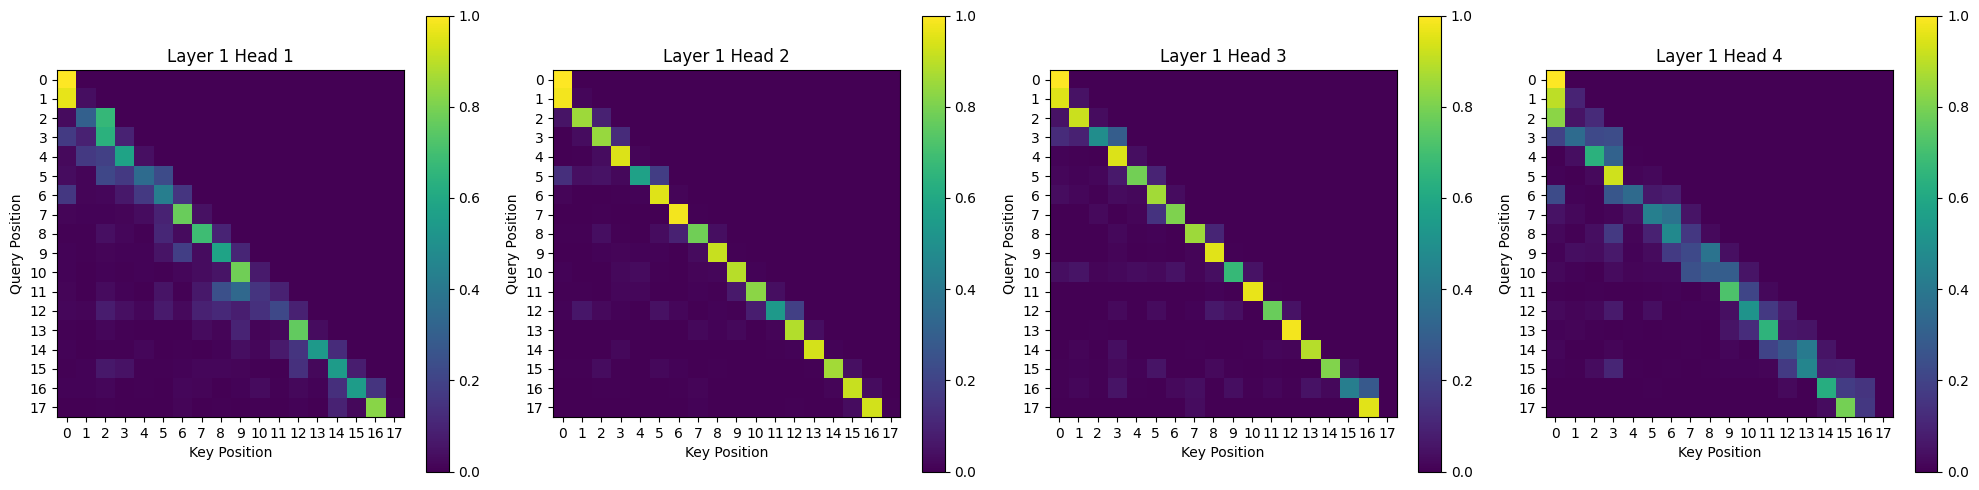

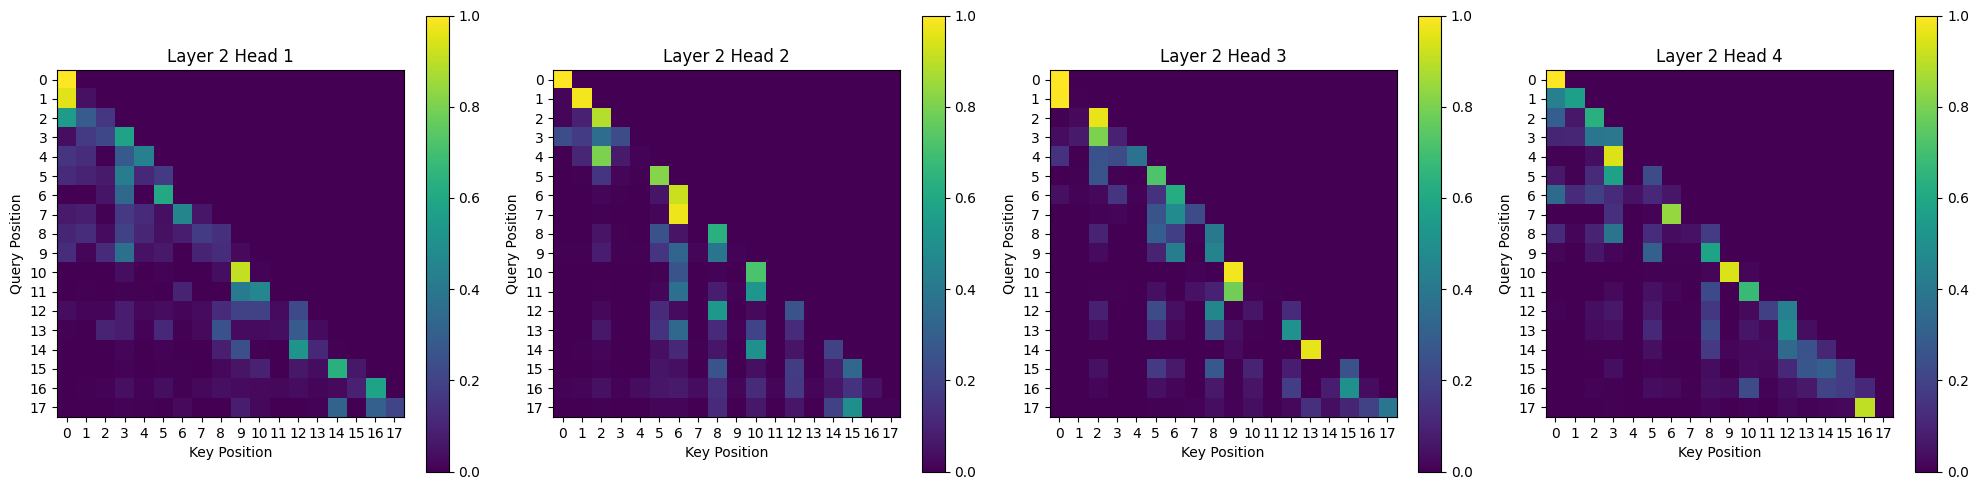

In [42]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

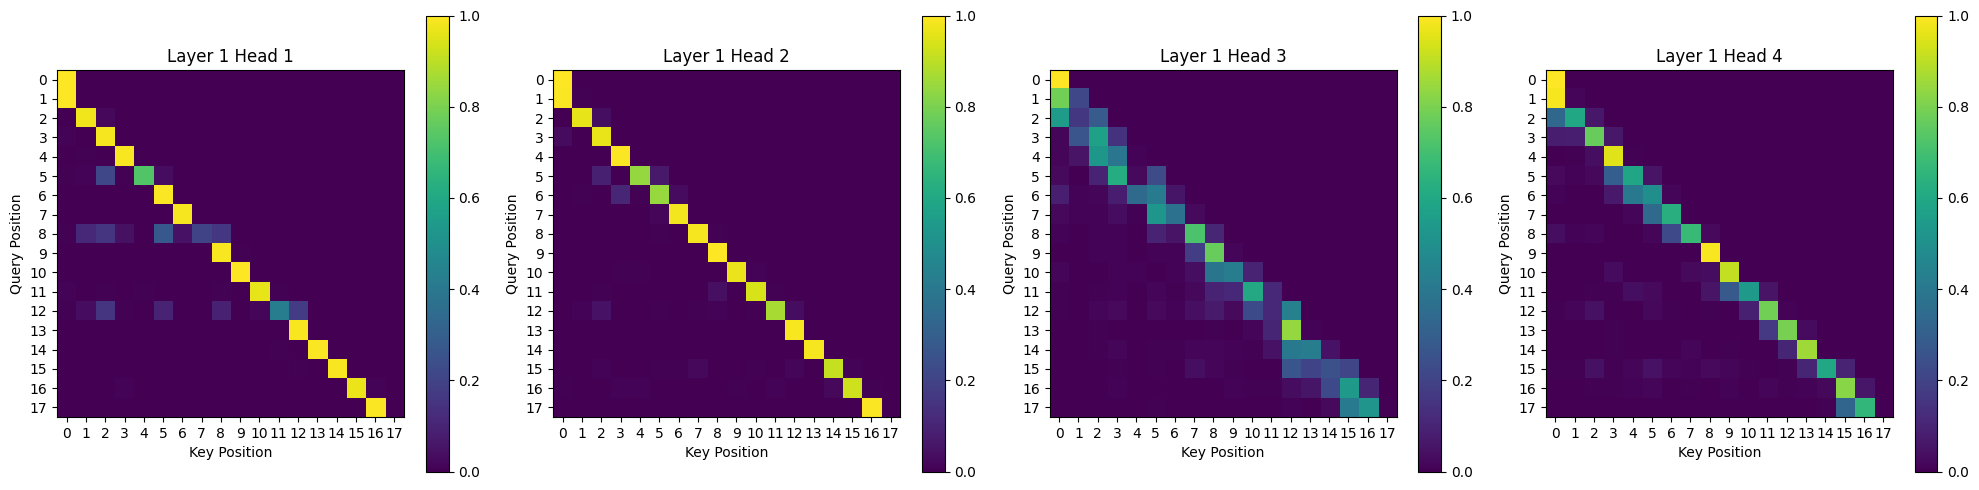

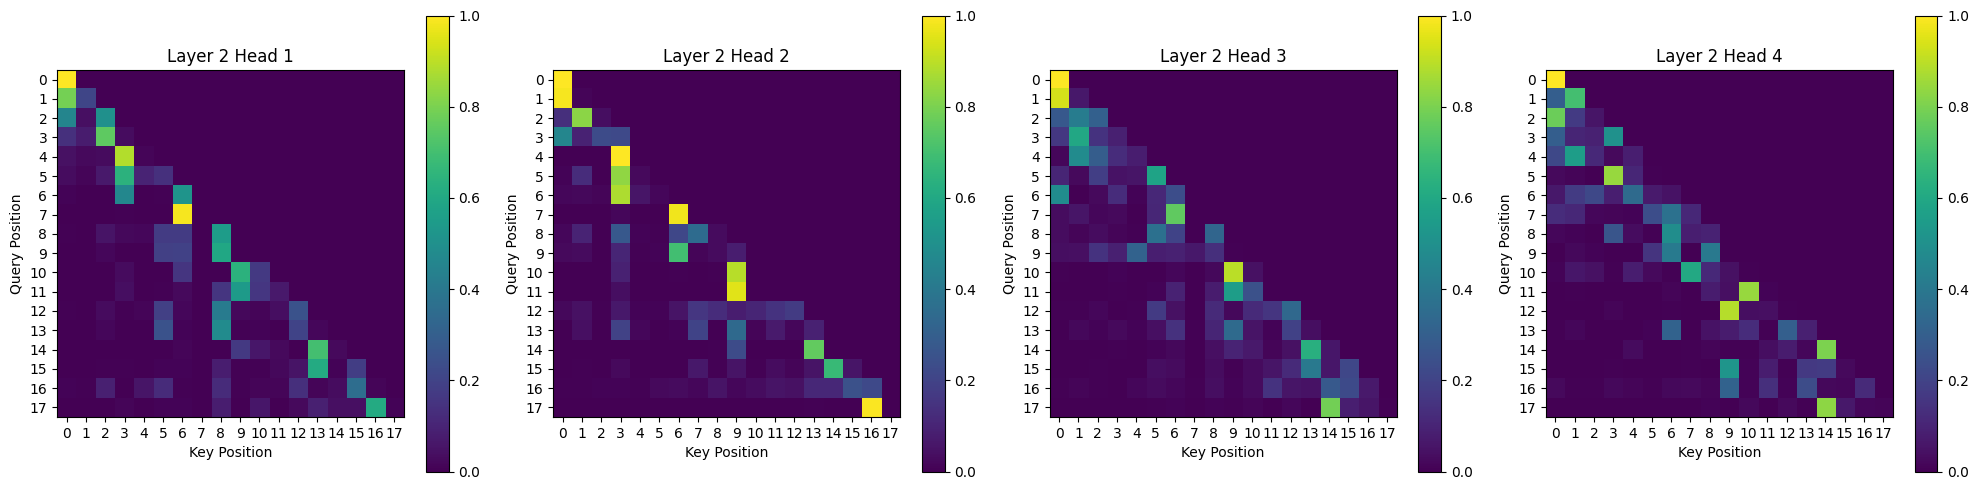

In [43]:
prompt = "To be or not to be"
visualize_attention(model_moe, prompt)

### Conclusions

- The MoE architecture represents a very effective approach to increase the performance of LLMs without increasing inference cost.

- LLM outputs can be tuned with temperature, from 0 (zero) for deterministic output to values greater than 1 for more creative results. A good balance is typically achieved between 0.80 and 0.90.

- Using top_p after top_k can be beneficial for bounding the output spectrum.

- Hyperparameters like context_length and embedding dimension are very relevant for capturing sequential dependencies and producing grammatically meaningful outputs. Computational cost will increase as these values are raised.

### Congratulations! 🎉

After completing the tasks you've successfully pretrained for first GPT, remember to add your conclusions and findings! And you can now brag to your friend on how LLMs and GPTs work!

